In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import shutil

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, Subset, DataLoader
from sklearn.model_selection import train_test_split
import timm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Managing Data in Required Format:
The current data structure contains patient-wise subfolders. Therefore, the first step is to copy all the images into the Covid, Healthy, and Other folders and remove all subfolders. Then, divide the data into training and testing sets using an 80% to 20% ratio

In [4]:
# Source folder: the original dataset folder where subfolders are organized by patient. 
source_folder = "./Dataset"

# Define the destination folder
destination_folder = "/New_Dataset"

# Check if the destination folder already exists; if it does, remove it.
if os.path.isdir(destination_folder):
    shutil.rmtree(destination_folder)

# Copy the source folder to the destination folder
shutil.copytree(source_folder, destination_folder)

print(f"{source_folder} copied to {destination_folder}.")


/kaggle/input/a-covid-multiclass-dataset-of-ct-scans/New_Data_CoV2 copied to /kaggle/working/New_Dataset.


In [5]:

base_dir = "./New_Dataset"
class_labels = [f for f in os.listdir(base_dir) if not f.startswith('.')]
print(f"Total lables available in dataset folder:{class_labels}")

for i in class_labels:
    new_dir = os.path.join(base_dir, i)

    # Walk through the main folder and its subdirectories
    for root, dirs, files in os.walk(new_dir):  
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                dest_path = os.path.join(new_dir, file)

                # Check if the file already exists in the destination directory
                if not os.path.exists(dest_path):
                    shutil.copy(file_path, dest_path)

                
    for root, dirs, _ in os.walk(new_dir, topdown=False):
        for dir in dirs:
            folder_to_remove = os.path.join(root, dir)
            shutil.rmtree(folder_to_remove)

Total lables available in dataset folder:['Covid', 'Healthy', 'Others']


In [6]:
# devide the data into training and testing set:
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


for label in class_labels:
    label_folder = os.path.join(base_dir, label)
    images = os.listdir(label_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=46)

    for image in train_images:
        src_path = os.path.join(label_folder, image)
        dest_path = os.path.join(train_dir, label, image)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        os.rename(src_path, dest_path)

    for image in test_images:
        src_path = os.path.join(label_folder, image)
        dest_path = os.path.join(test_dir, label, image)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        os.rename(src_path, dest_path)
        
#Remove the other folders except "Train" and "Test"
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if folder_name not in ['Train', 'Test'] and os.path.isdir(folder_path):
        shutil.rmtree(folder_path)

# Data Pre-Processing

In [7]:

class CustomDataset:

    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform  
        
        # Create an ImageFolder dataset 
        self.dataset = ImageFolder(root, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return img, label

# Define data transforms  to  calculate sample mean and std.
MyTransform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert image to grayscale
    transforms.Resize((224, 224)),  # resize the image
    transforms.ColorJitter(brightness=0.3, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=(-30, 30), translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# Create train dataset to compute mean and std
train_dataset = CustomDataset(train_dir, transform=MyTransform)

# mean and std
mean = 0.0
std = 0.0
for i in range(len(train_dataset)):
    img, _ = train_dataset[i]
    mean += img.mean()
    std += img.std()

mean /= len(train_dataset) # sample mean
std /= len(train_dataset) #sample std



# This transform for model input
MyTransform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert image to grayscale
    transforms.Resize((224, 224)),  
    transforms.ColorJitter(brightness=0.3, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=(-15, 15), translate=(0.1, 0.1)),
    transforms.ToTensor(),  # Transform from [0,255] uint8 to [0,1] float
    transforms.Normalize([mean], [std]) # used calculated sample mean and std.
])

# Create train and test datasets with the updated transform
DATA_train = CustomDataset(train_dir, transform=MyTransform)
DATA_test = CustomDataset(test_dir, transform=MyTransform)

# CNN Architechture: ResNet-50:

In [8]:

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pretrained ResNet-50
        self.model_resnet = models.resnet50(pretrained=True)

        # Modify the first convolutional layer to accept one channel
        self.model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=1)

        # Set ResNet-50's FCN as an identity mapping
        num_fc_in = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()

        # FCN design
        self.fc1 = nn.Linear(num_fc_in, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        # Extract features from ResNet-50
        features = self.model_resnet(x)

        # FCN
        x = self.fc1(features)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

Input (1 channel)
|
v
Modified Conv2d (1 -> 64, kernel=5, stride=2, padding=1)
|
v
ResNet-50 (pre-trained)
|
v
Flatten
|
v
FC(512) -> ReLU -> FC(256) -> ReLU -> Dropout(0.2) -> FC(3)
|
v
Output (3 classes)

In [9]:
# Define batch size, loss function and optimizer
trainloader = DataLoader(DATA_train, batch_size=64, shuffle=True,)
testloader = DataLoader(DATA_test, batch_size=64, shuffle=True)

# Configure device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = Network().to(device)
#Loss function
loss_fn = nn.CrossEntropyLoss()  
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s] 


# Define train and test function

In [10]:
train_losses=[]
train_accu=[]
def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for data in tqdm(trainloader):
     
    inputs,labels=data[0].to(device),data[1].to(device)
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
       
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
   
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    
test_losses=[]
test_accu=[]
 
def test(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)
       
      outputs=model(images)
 
      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
   
  test_loss=running_loss/len(testloader)
  accu=100.*correct/total
 
  test_losses.append(test_loss)
  test_accu.append(accu)
 
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))
    
    



In [11]:
epochs=50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 48/48 [00:43<00:00,  1.11it/s]


Train Loss: 0.860 | Accuracy: 56.622


100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Test Loss: 0.894 | Accuracy: 53.604

Epoch : 2


100%|██████████| 48/48 [00:37<00:00,  1.29it/s]


Train Loss: 0.770 | Accuracy: 63.621


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Test Loss: 0.861 | Accuracy: 54.915

Epoch : 3


100%|██████████| 48/48 [00:37<00:00,  1.28it/s]


Train Loss: 0.668 | Accuracy: 70.983


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Test Loss: 0.776 | Accuracy: 66.841

Epoch : 4


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.612 | Accuracy: 72.659


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Test Loss: 0.874 | Accuracy: 65.793

Epoch : 5


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.590 | Accuracy: 73.677


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Test Loss: 0.638 | Accuracy: 68.021

Epoch : 6


100%|██████████| 48/48 [00:37<00:00,  1.30it/s]


Train Loss: 0.616 | Accuracy: 73.447


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Test Loss: 0.594 | Accuracy: 73.263

Epoch : 7


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.547 | Accuracy: 76.569


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Test Loss: 0.528 | Accuracy: 76.671

Epoch : 8


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.507 | Accuracy: 77.818


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Test Loss: 0.519 | Accuracy: 77.588

Epoch : 9


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.512 | Accuracy: 78.475


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Test Loss: 0.745 | Accuracy: 68.021

Epoch : 10


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.512 | Accuracy: 78.377


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Test Loss: 0.800 | Accuracy: 68.021

Epoch : 11


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.453 | Accuracy: 80.578


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Test Loss: 0.511 | Accuracy: 74.705

Epoch : 12


100%|██████████| 48/48 [00:37<00:00,  1.29it/s]


Train Loss: 0.440 | Accuracy: 80.973


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Test Loss: 0.495 | Accuracy: 78.768

Epoch : 13


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.442 | Accuracy: 81.466


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Test Loss: 0.712 | Accuracy: 67.497

Epoch : 14


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.431 | Accuracy: 81.761


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Test Loss: 0.438 | Accuracy: 80.472

Epoch : 15


100%|██████████| 48/48 [00:36<00:00,  1.33it/s]


Train Loss: 0.419 | Accuracy: 82.517


100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Test Loss: 0.444 | Accuracy: 83.486

Epoch : 16


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.401 | Accuracy: 83.076


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Test Loss: 0.491 | Accuracy: 80.865

Epoch : 17


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.376 | Accuracy: 84.752


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Test Loss: 0.575 | Accuracy: 76.278

Epoch : 18


100%|██████████| 48/48 [00:37<00:00,  1.29it/s]


Train Loss: 0.380 | Accuracy: 84.160


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Test Loss: 0.618 | Accuracy: 74.836

Epoch : 19


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.389 | Accuracy: 84.752


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Test Loss: 0.623 | Accuracy: 76.409

Epoch : 20


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.343 | Accuracy: 86.264


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Test Loss: 0.595 | Accuracy: 76.409

Epoch : 21


100%|██████████| 48/48 [00:37<00:00,  1.28it/s]


Train Loss: 0.333 | Accuracy: 87.249


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Test Loss: 0.684 | Accuracy: 73.132

Epoch : 22


100%|██████████| 48/48 [00:38<00:00,  1.24it/s]


Train Loss: 0.320 | Accuracy: 86.888


100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Test Loss: 0.441 | Accuracy: 81.913

Epoch : 23


100%|██████████| 48/48 [00:37<00:00,  1.27it/s]


Train Loss: 0.305 | Accuracy: 88.432


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Test Loss: 0.933 | Accuracy: 71.298

Epoch : 24


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.304 | Accuracy: 87.151


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Test Loss: 0.614 | Accuracy: 79.292

Epoch : 25


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.305 | Accuracy: 88.235


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Test Loss: 0.560 | Accuracy: 78.768

Epoch : 26


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.278 | Accuracy: 88.827


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Test Loss: 0.403 | Accuracy: 84.797

Epoch : 27


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.278 | Accuracy: 88.794


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Test Loss: 0.738 | Accuracy: 73.263

Epoch : 28


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.292 | Accuracy: 88.597


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Test Loss: 0.421 | Accuracy: 83.748

Epoch : 29


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.261 | Accuracy: 89.648


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Test Loss: 0.380 | Accuracy: 85.583

Epoch : 30


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.246 | Accuracy: 90.076


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Test Loss: 0.464 | Accuracy: 80.210

Epoch : 31


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.260 | Accuracy: 89.385


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Test Loss: 0.541 | Accuracy: 81.127

Epoch : 32


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.222 | Accuracy: 91.456


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Test Loss: 0.486 | Accuracy: 82.700

Epoch : 33


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.270 | Accuracy: 90.273


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Test Loss: 0.369 | Accuracy: 86.107

Epoch : 34


100%|██████████| 48/48 [00:37<00:00,  1.30it/s]


Train Loss: 0.215 | Accuracy: 91.817


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Test Loss: 0.648 | Accuracy: 82.045

Epoch : 35


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.207 | Accuracy: 91.784


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Test Loss: 0.549 | Accuracy: 79.423

Epoch : 36


100%|██████████| 48/48 [00:37<00:00,  1.28it/s]


Train Loss: 0.218 | Accuracy: 91.226


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Test Loss: 0.627 | Accuracy: 79.292

Epoch : 37


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.208 | Accuracy: 92.080


100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Test Loss: 0.493 | Accuracy: 82.307

Epoch : 38


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.195 | Accuracy: 92.409


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Test Loss: 0.498 | Accuracy: 82.962

Epoch : 39


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.189 | Accuracy: 92.277


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Test Loss: 0.411 | Accuracy: 85.321

Epoch : 40


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.196 | Accuracy: 92.540


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Test Loss: 0.420 | Accuracy: 82.438

Epoch : 41


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.190 | Accuracy: 92.442


100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Test Loss: 0.573 | Accuracy: 81.389

Epoch : 42


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.196 | Accuracy: 92.935


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Test Loss: 0.325 | Accuracy: 88.073

Epoch : 43


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.173 | Accuracy: 93.559


100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Test Loss: 0.884 | Accuracy: 77.851

Epoch : 44


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.173 | Accuracy: 93.066


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Test Loss: 0.504 | Accuracy: 81.913

Epoch : 45


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.153 | Accuracy: 94.643


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Test Loss: 0.302 | Accuracy: 89.253

Epoch : 46


100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Train Loss: 0.154 | Accuracy: 94.216


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Test Loss: 0.408 | Accuracy: 85.583

Epoch : 47


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.136 | Accuracy: 94.775


100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Test Loss: 1.267 | Accuracy: 71.822

Epoch : 48


100%|██████████| 48/48 [00:36<00:00,  1.32it/s]


Train Loss: 0.178 | Accuracy: 93.296


100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Test Loss: 0.328 | Accuracy: 87.418

Epoch : 49


100%|██████████| 48/48 [00:36<00:00,  1.30it/s]


Train Loss: 0.141 | Accuracy: 94.742


100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Test Loss: 0.558 | Accuracy: 82.045

Epoch : 50


100%|██████████| 48/48 [00:37<00:00,  1.30it/s]


Train Loss: 0.147 | Accuracy: 94.479


100%|██████████| 12/12 [00:06<00:00,  1.83it/s]

Test Loss: 0.347 | Accuracy: 87.811


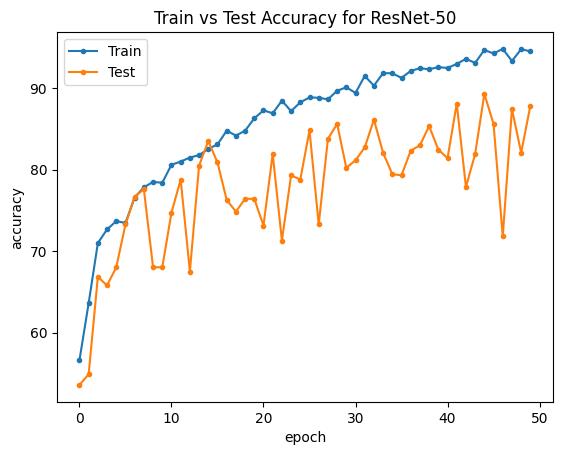

In [12]:
plt.plot(train_accu,'-o', markersize=3)
plt.plot(test_accu,'-o', markersize=3)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy for ResNet-50')
# plt.savefig("traintest_resnet.png")
plt.show()

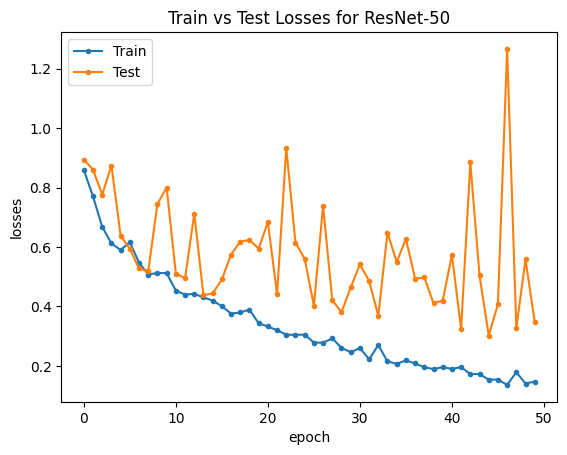

In [13]:
plt.plot(train_losses,'-o', markersize=3)
plt.plot(test_losses,'-o', markersize=3)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses for ResNet-50')
 
plt.show()

# efficientnet_b0 Model 

In [14]:

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Load pretrained EfficientNet-B0
        self.model_efficientnet = timm.create_model('efficientnet_b0', pretrained=True)

        # Modify the first convolutional layer to accept one channel
        self.model_efficientnet.conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Set EfficientNet-B0's classifier as an identity mapping
        num_fc_in = self.model_efficientnet.classifier.in_features
        self.model_efficientnet.classifier = nn.Identity()

        # FCN
        self.fc1 = nn.Linear(num_fc_in, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 3)

    def forward(self, x):
        features = self.model_efficientnet(x)

        # FCN
        x = self.fc1(features)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x


In [15]:
# Define batch size, loss function and optimizer
trainloader = DataLoader(DATA_train, batch_size=64, shuffle=True,)
testloader = DataLoader(DATA_test, batch_size=64, shuffle=True)

# Configure device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = Network().to(device)
#Loss function
loss_fn = nn.CrossEntropyLoss()  
#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
train_losses=[]
train_accu=[]
def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for data in tqdm(trainloader):
     
    inputs,labels=data[0].to(device),data[1].to(device)
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
       
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
   
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    
test_losses=[]
test_accu=[]
 
def test(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)
       
      outputs=model(images)
 
      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
   
  test_loss=running_loss/len(testloader)
  accu=100.*correct/total
 
  test_losses.append(test_loss)
  test_accu.append(accu)
 
  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))
    
    



In [17]:
epochs=50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


Train Loss: 0.788 | Accuracy: 61.847


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.579 | Accuracy: 71.822

Epoch : 2


100%|██████████| 48/48 [00:33<00:00,  1.45it/s]


Train Loss: 0.534 | Accuracy: 78.442


100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Test Loss: 0.444 | Accuracy: 82.700

Epoch : 3


100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


Train Loss: 0.404 | Accuracy: 83.700


100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Test Loss: 0.409 | Accuracy: 82.438

Epoch : 4


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Loss: 0.393 | Accuracy: 83.602


100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Test Loss: 0.376 | Accuracy: 85.190

Epoch : 5


100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


Train Loss: 0.303 | Accuracy: 88.301


100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Test Loss: 0.406 | Accuracy: 84.928

Epoch : 6


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Loss: 0.267 | Accuracy: 90.174


100%|██████████| 12/12 [00:06<00:00,  1.99it/s]


Test Loss: 0.282 | Accuracy: 89.908

Epoch : 7


100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


Train Loss: 0.231 | Accuracy: 91.291


100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Test Loss: 0.414 | Accuracy: 86.501

Epoch : 8


100%|██████████| 48/48 [00:32<00:00,  1.50it/s]


Train Loss: 0.202 | Accuracy: 92.475


100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Test Loss: 0.506 | Accuracy: 83.617

Epoch : 9


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Loss: 0.207 | Accuracy: 92.573


100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Test Loss: 0.262 | Accuracy: 90.695

Epoch : 10


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Loss: 0.154 | Accuracy: 94.972


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.353 | Accuracy: 87.418

Epoch : 11


100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


Train Loss: 0.160 | Accuracy: 94.775


100%|██████████| 12/12 [00:05<00:00,  2.01it/s]


Test Loss: 0.223 | Accuracy: 91.874

Epoch : 12


100%|██████████| 48/48 [00:32<00:00,  1.50it/s]


Train Loss: 0.141 | Accuracy: 95.202


100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Test Loss: 0.270 | Accuracy: 90.564

Epoch : 13


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.129 | Accuracy: 96.089


100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Test Loss: 0.313 | Accuracy: 89.908

Epoch : 14


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.151 | Accuracy: 94.742


100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Test Loss: 0.226 | Accuracy: 91.350

Epoch : 15


100%|██████████| 48/48 [00:33<00:00,  1.42it/s]


Train Loss: 0.100 | Accuracy: 96.615


100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Test Loss: 0.381 | Accuracy: 88.467

Epoch : 16


100%|██████████| 48/48 [00:33<00:00,  1.45it/s]


Train Loss: 0.116 | Accuracy: 96.057


100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Test Loss: 0.277 | Accuracy: 92.792

Epoch : 17


100%|██████████| 48/48 [00:32<00:00,  1.46it/s]


Train Loss: 0.088 | Accuracy: 96.944


100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Test Loss: 0.204 | Accuracy: 92.661

Epoch : 18


100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


Train Loss: 0.094 | Accuracy: 97.240


100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Test Loss: 0.276 | Accuracy: 91.481

Epoch : 19


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Loss: 0.105 | Accuracy: 96.319


100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Test Loss: 0.199 | Accuracy: 93.840

Epoch : 20


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.054 | Accuracy: 98.160


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.296 | Accuracy: 92.923

Epoch : 21


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.081 | Accuracy: 96.944


100%|██████████| 12/12 [00:06<00:00,  1.90it/s]


Test Loss: 0.259 | Accuracy: 91.612

Epoch : 22


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.050 | Accuracy: 98.521


100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Test Loss: 0.205 | Accuracy: 94.233

Epoch : 23


100%|██████████| 48/48 [00:32<00:00,  1.46it/s]


Train Loss: 0.057 | Accuracy: 98.291


100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Test Loss: 0.183 | Accuracy: 94.233

Epoch : 24


100%|██████████| 48/48 [00:33<00:00,  1.45it/s]


Train Loss: 0.056 | Accuracy: 98.258


100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Test Loss: 0.155 | Accuracy: 94.102

Epoch : 25


100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Train Loss: 0.062 | Accuracy: 97.864


100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Test Loss: 0.266 | Accuracy: 92.923

Epoch : 26


100%|██████████| 48/48 [00:32<00:00,  1.46it/s]


Train Loss: 0.049 | Accuracy: 98.521


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.230 | Accuracy: 93.971

Epoch : 27


100%|██████████| 48/48 [00:31<00:00,  1.51it/s]


Train Loss: 0.057 | Accuracy: 98.061


100%|██████████| 12/12 [00:05<00:00,  2.02it/s]


Test Loss: 0.180 | Accuracy: 93.971

Epoch : 28


100%|██████████| 48/48 [00:31<00:00,  1.51it/s]


Train Loss: 0.059 | Accuracy: 97.733


100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Test Loss: 0.284 | Accuracy: 92.923

Epoch : 29


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.050 | Accuracy: 98.521


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.189 | Accuracy: 94.495

Epoch : 30


100%|██████████| 48/48 [00:32<00:00,  1.48it/s]


Train Loss: 0.056 | Accuracy: 97.864


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Test Loss: 0.222 | Accuracy: 94.495

Epoch : 31


100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Train Loss: 0.062 | Accuracy: 97.930


100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Test Loss: 0.192 | Accuracy: 94.364

Epoch : 32


100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Train Loss: 0.032 | Accuracy: 98.916


100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Test Loss: 0.234 | Accuracy: 94.495

Epoch : 33


100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Train Loss: 0.069 | Accuracy: 97.831


100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Test Loss: 0.204 | Accuracy: 93.185

Epoch : 34


100%|██████████| 48/48 [00:33<00:00,  1.43it/s]


Train Loss: 0.033 | Accuracy: 98.916


100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Test Loss: 0.271 | Accuracy: 92.136

Epoch : 35


100%|██████████| 48/48 [00:32<00:00,  1.46it/s]


Train Loss: 0.047 | Accuracy: 98.751


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.182 | Accuracy: 95.282

Epoch : 36


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.049 | Accuracy: 98.455


100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Test Loss: 0.200 | Accuracy: 94.233

Epoch : 37


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.030 | Accuracy: 99.047


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.205 | Accuracy: 94.889

Epoch : 38


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.045 | Accuracy: 98.521


100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Test Loss: 0.266 | Accuracy: 93.447

Epoch : 39


100%|██████████| 48/48 [00:33<00:00,  1.45it/s]


Train Loss: 0.050 | Accuracy: 98.521


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.246 | Accuracy: 93.185

Epoch : 40


100%|██████████| 48/48 [00:32<00:00,  1.46it/s]


Train Loss: 0.051 | Accuracy: 98.390


100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Test Loss: 0.252 | Accuracy: 93.447

Epoch : 41


100%|██████████| 48/48 [00:32<00:00,  1.46it/s]


Train Loss: 0.035 | Accuracy: 98.850


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.210 | Accuracy: 93.316

Epoch : 42


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Loss: 0.047 | Accuracy: 98.258


100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Test Loss: 0.192 | Accuracy: 95.020

Epoch : 43


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.038 | Accuracy: 98.883


100%|██████████| 12/12 [00:06<00:00,  1.98it/s]


Test Loss: 0.268 | Accuracy: 94.889

Epoch : 44


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Loss: 0.018 | Accuracy: 99.343


100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Test Loss: 0.300 | Accuracy: 94.626

Epoch : 45


100%|██████████| 48/48 [00:32<00:00,  1.49it/s]


Train Loss: 0.034 | Accuracy: 99.014


100%|██████████| 12/12 [00:06<00:00,  2.00it/s]


Test Loss: 0.184 | Accuracy: 96.068

Epoch : 46


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.014 | Accuracy: 99.507


100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Test Loss: 0.321 | Accuracy: 94.233

Epoch : 47


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.076 | Accuracy: 97.568


100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Test Loss: 0.282 | Accuracy: 93.054

Epoch : 48


100%|██████████| 48/48 [00:33<00:00,  1.45it/s]


Train Loss: 0.048 | Accuracy: 98.423


100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Test Loss: 0.306 | Accuracy: 92.529

Epoch : 49


100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Train Loss: 0.054 | Accuracy: 97.963


100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


Test Loss: 0.209 | Accuracy: 94.626

Epoch : 50


100%|██████████| 48/48 [00:32<00:00,  1.47it/s]


Train Loss: 0.036 | Accuracy: 98.948


100%|██████████| 12/12 [00:06<00:00,  1.94it/s]

Test Loss: 0.275 | Accuracy: 92.136


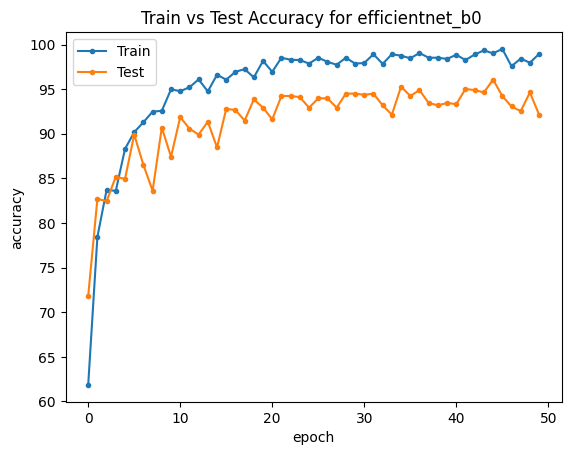

In [18]:
plt.plot(train_accu,'-o', markersize=3)
plt.plot(test_accu,'-o', markersize=3)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy for efficientnet_b0 ')
 
plt.show()

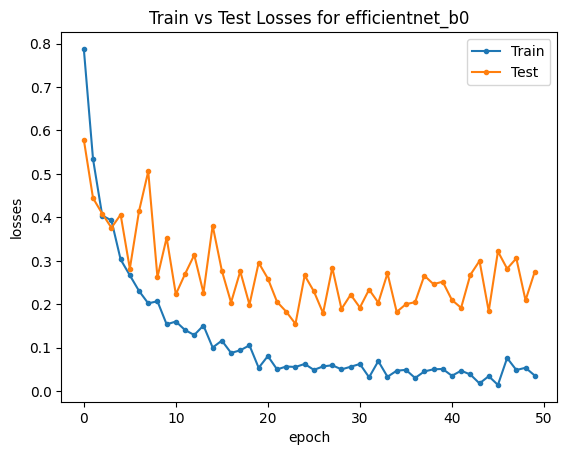

In [19]:
plt.plot(train_losses,'-o', markersize=3)
plt.plot(test_losses,'-o', markersize=3)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses for efficientnet_b0')
 
plt.show()